# Acoustic seismic wave propagation

In [1]:
# Importing libraries
# ----------------
import numpy as np
from numba import jit
from scipy import misc
import matplotlib, time
from pylab import rcParams
import matplotlib.pyplot as plt
# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

## Loading the model

In [2]:
# loading the P-wave velocity model - simple model just for testing the code
vp = np.loadtxt('Vp-made up model.txt', delimiter = ',')

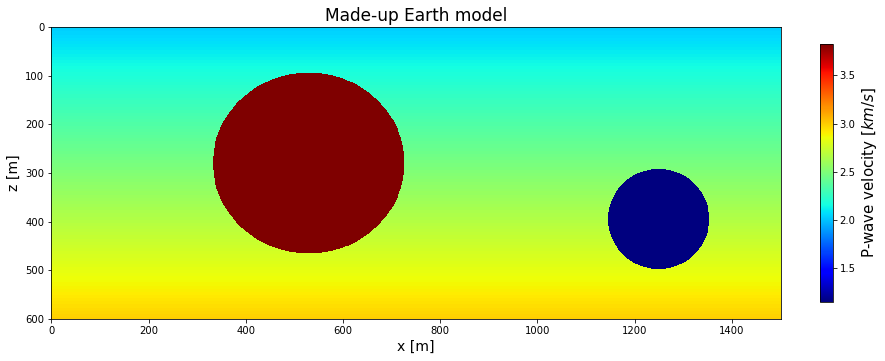

In [4]:
# Visualization I
plt.figure(figsize = (14, 12))
plt.title('Made-up Earth model', fontsize = 17)

# Grid lines at these intervals (in pixels)
# dx and dz can be different
dx   = 25     # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)

nx = 1500
nz = 600

xmax = nx
zmax = nz

extent = [0, xmax, zmax, 0]

im = plt.imshow((vp.T)/1000, cmap='jet', interpolation='nearest', 
                   extent=extent)

cbar = plt.colorbar(im, fraction=0.0165, pad=0.05)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='P-wave velocity $[km/s]$', size=15)

# plt.grid()
plt.xlabel('x [m]', fontsize = 14)
plt.ylabel('z [m]', fontsize = 14)
plt.show()

## Seismic forward problem

In [5]:
@jit(nopython=True) # use JIT for C-performance - 3 point FD
def update_d2px_d2pz_3pt(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz

In [6]:
@jit(nopython=True) # use JIT for C-performance - 5 point FD
def update_d2px_d2pz_5pt(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(2, nx - 2):
        for j in range(2, nz - 2):
            d2px[i,j] = (-1/12 * p[i + 2, j] + 4/3 * p[i + 1, j] - 5/2 * p[i, j] + 4/3 * p[i - 1, j] - 1/12 * p[i - 2, j]) / dx**2               
            d2pz[i,j] = (-1/12 * p[i, j + 2] + 4/3 * p[i, j + 1] - 5/2 * p[i, j] + 4/3 * p[i, j - 1] - 1/12 * p[i, j - 2]) / dz**2
        
    return d2px, d2pz

In [7]:
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 50     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

In [8]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def seis_forward(vp,dt,dx,dz,f0,xsrc,zsrc,op,s_seis,e_seis,i_seis,d_seis):        
    
    # calculate number of time steps nt 
    # ---------------------------------
    nt = (int)(tmax/dt)
    
    # locate source on Cartesian FD grid
    # ----------------------------------
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction    
    
    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2)) 
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.5 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Define squared vp-model
    # -----------------------        
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p 
    rcParams
    # INITIALIZE SEISMOGRAMS HERE!
    # ----------------------------
    irx = (np.arange(s_seis, e_seis, i_seis) / dx).astype(int)
    irz = (np.ones(len(irx)) * (d_seis / dz)).astype(int)
    seis = np.zeros((len(irx), nt))
    ir = np.arange(len(irx))
        
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(10,8))  # define figure size
    extent = [xmin,xmax,zmax,zmin]     # define model extension
    
#     Plot Vp-model
    image = plt.imshow((vp.T)/1000, cmap='Greys', interpolation='nearest', 
                        extent=extent)
    cbar = plt.colorbar(image, fraction=0.0165, pad=0.05)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='P-wave velocity [km/s]', size=15)
    
#     Plot pressure wavefield movie
    image1 = plt.imshow(p.T, animated=True, cmap="seismic", alpha=.75, extent=extent, 
                          interpolation='nearest', vmin=-clip, vmax=clip)    
    plt.title('Pressure wavefield', fontsize = 14)
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    
#     Plot the receivers
    for x, z in zip(irx, irz):
        plt.text(x, z, 'v')

    plt.text(xsrc, zsrc, '*', fontsize = 50)

    
#     plt.ion()    
#     plt.show(block=False)
    
    # Calculate Partial Derivatives
    # -----------------------------
    
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        if(op==3):
            d2px, d2pz = update_d2px_d2pz_3pt(p, dx, dz, nx, nz, d2px, d2pz)
        
        # ADD FD APPROXIMATION OF SPATIAL DERIVATIVES BY 5 POINT OPERATOR HERE!
        if(op==5):
            d2px, d2pz = update_d2px_d2pz_5pt(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
        
        # Apply absorbing boundary frame
        # ------------------------------
        p *= absorb_coeff
        pnew *= absorb_coeff
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
        
        # WRITE SEISMOGRAMS HERE!
        # Save seismograms
        seis[ir, it] = p.T[irz[ir].astype(int), irx[ir].astype(int)]
        
        # display pressure snapshots
        if (it % isnap) == 0:            
            image1.set_data(p.T)
            fig.canvas.draw()
    
    return seis
# , p

### Acquisition geometry

In [9]:
# Definition of modelling parameters
# ----------------------------------
tmax = 8        # maximum wave propagation time (s)

xsrc = 18750   # x-source position (m)
zsrc = 100.0    # z-source position (m)
vp0  = vp.max()    # P-wave speed in medium (m/s)
vpmax = vp0

xmin = 0
xmax = 1500
zmin = 0
zmax = 600

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(3.0) * vpmax)

# number of operators
op = 5

# number of time steps
nt = (int)(tmax/dt)

# receiver locations (m)
s_seis = 2500
e_seis = 35000
i_seis = 100
d_seis = 100

extent_seis = [xmin, xmax, nt * dt, 0]

# snapshot interval (timesteps)
isnap = 10

# dominant frequency of the source (Hz)
f0 = 40
t0   = 4.0/f0   # source time shift (s)


print('***Survey Parameters***', "\n Dominant frequency of the source = ", f0, 
      " Hz", "\n Maximum time = ", tmax, "s", "\n Sampling time based on CFL criterion = ", round(dt*1000, 2), "ms",
      "\n Number of time steps = ", nt, '\n Number of operators in FD = ', 
      op, '\n Source location in grid = ', [(int)(xsrc/dx), (int)(zsrc/dz)])

***Survey Parameters*** 
 Dominant frequency of the source =  40  Hz 
 Maximum time =  8 s 
 Sampling time based on CFL criterion =  3.77 ms 
 Number of time steps =  2120 
 Number of operators in FD =  5 
 Source location in grid =  [750, 4]


### Performing forward modeling (measurement)

<IPython.core.display.Javascript object>


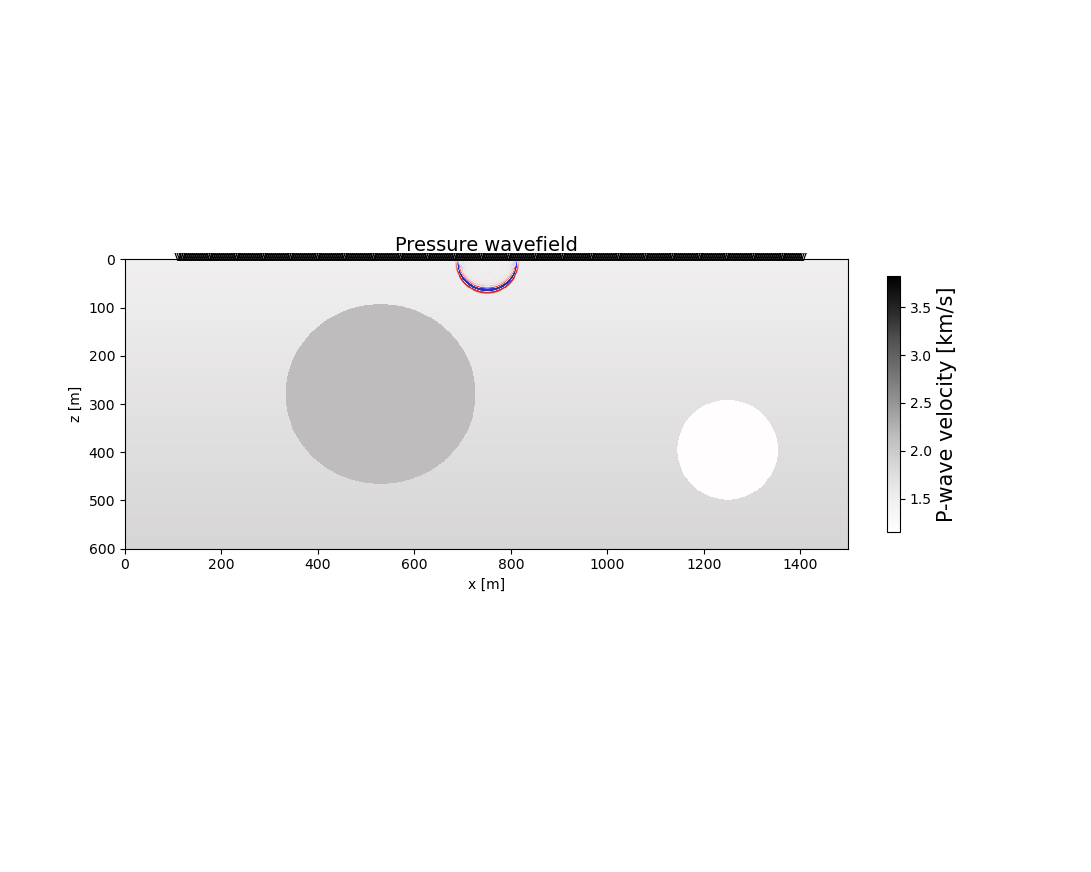

In [ ]:
%matplotlib notebook

start_time = time.time()
seis_true = seis_forward((vp),dt,dx,dz,f0,xsrc,zsrc,op,s_seis,e_seis,i_seis,d_seis)
end_time = time.time()
print('Forward modeling time: ', end_time - start_time)

### True response

<IPython.core.display.Javascript object>


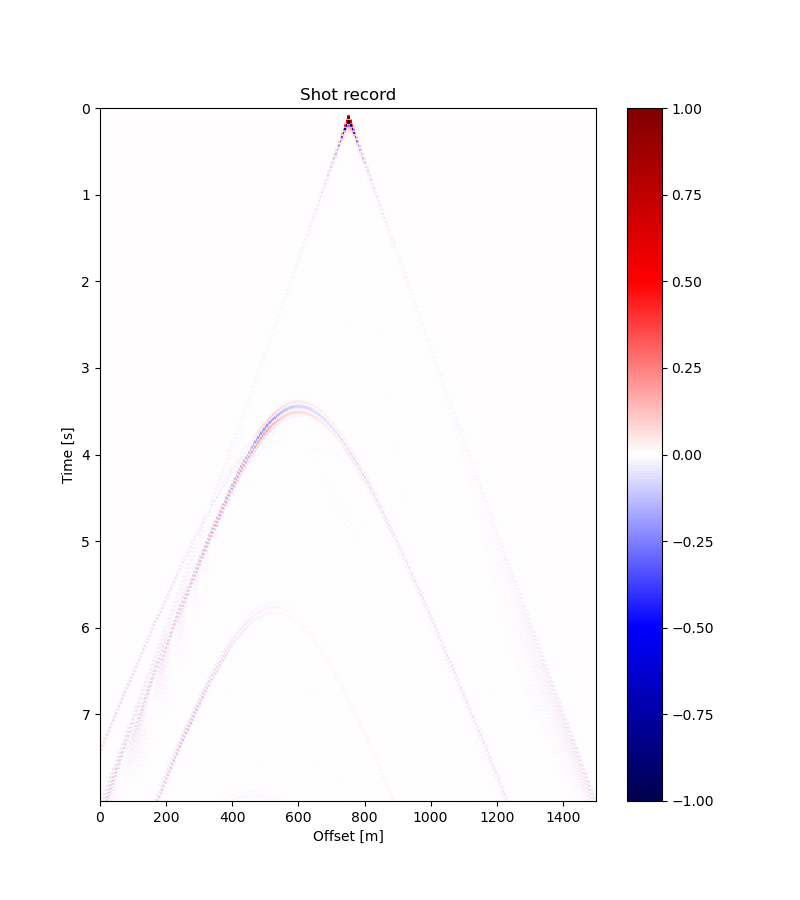

In [10]:
# from sklearn.preprocessing import StandardScaler
# seis = StandardScaler().fit_transform(seis)

time = np.arange(0,nt)
ymax = seis_true.ravel().max()

# Plot the source time function and the seismograms 

plt.figure(figsize=(8, 9))

# ymax = seis.ravel().max()
# for ir in range(len(seis)):
#     plt.plot(time, seis[ir, :] + ymax * ir, 'k')
#     plt.title('Seismograms')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')

plt.imshow(seis_true.T * 1e6, aspect = "auto", cmap = "seismic", interpolation='nearest', extent=extent_seis, vmin = -1, vmax = 1.)
plt.title('Shot record')
plt.xlabel('Offset [m]')
plt.ylabel('Time [s]')
plt.colorbar()
plt.show()